In [4]:
%matplotlib inline

# dependencies
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

import time
import os.path
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
from random import randrange
import missingno as msno
import cv2
from math import sin, cos, pi

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, GlobalAveragePooling2D, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras import optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB7, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

np.random.seed(0)
print ("OK")
import tensorflow as tf
print("Tensorflow version", tf.__version__)

OK
Tensorflow version 2.8.0


# Load Data

In [5]:
#Checking to see if the train/test csv are loaded, if not, unzip from dir
if (os.path.exists('training.csv') == False):
    !unzip training.zip
else:
    print('training data already unzipped')

if (os.path.exists('test.csv') == False):
    !unzip test.zip
else:
    print('test data already unzipped')

# load data
train = pd.read_csv('~/Dropbox/Berkeley_DS/w207/mids_w207_final_project/training.csv')
test = pd.read_csv('~/Dropbox/Berkeley_DS/w207/mids_w207_final_project/test.csv')
print(train.shape)
print(test.shape)

unzip:  cannot find or open training.zip, training.zip.zip or training.zip.ZIP.
unzip:  cannot find or open test.zip, test.zip.zip or test.zip.ZIP.
(7049, 31)
(1783, 2)


# EDA

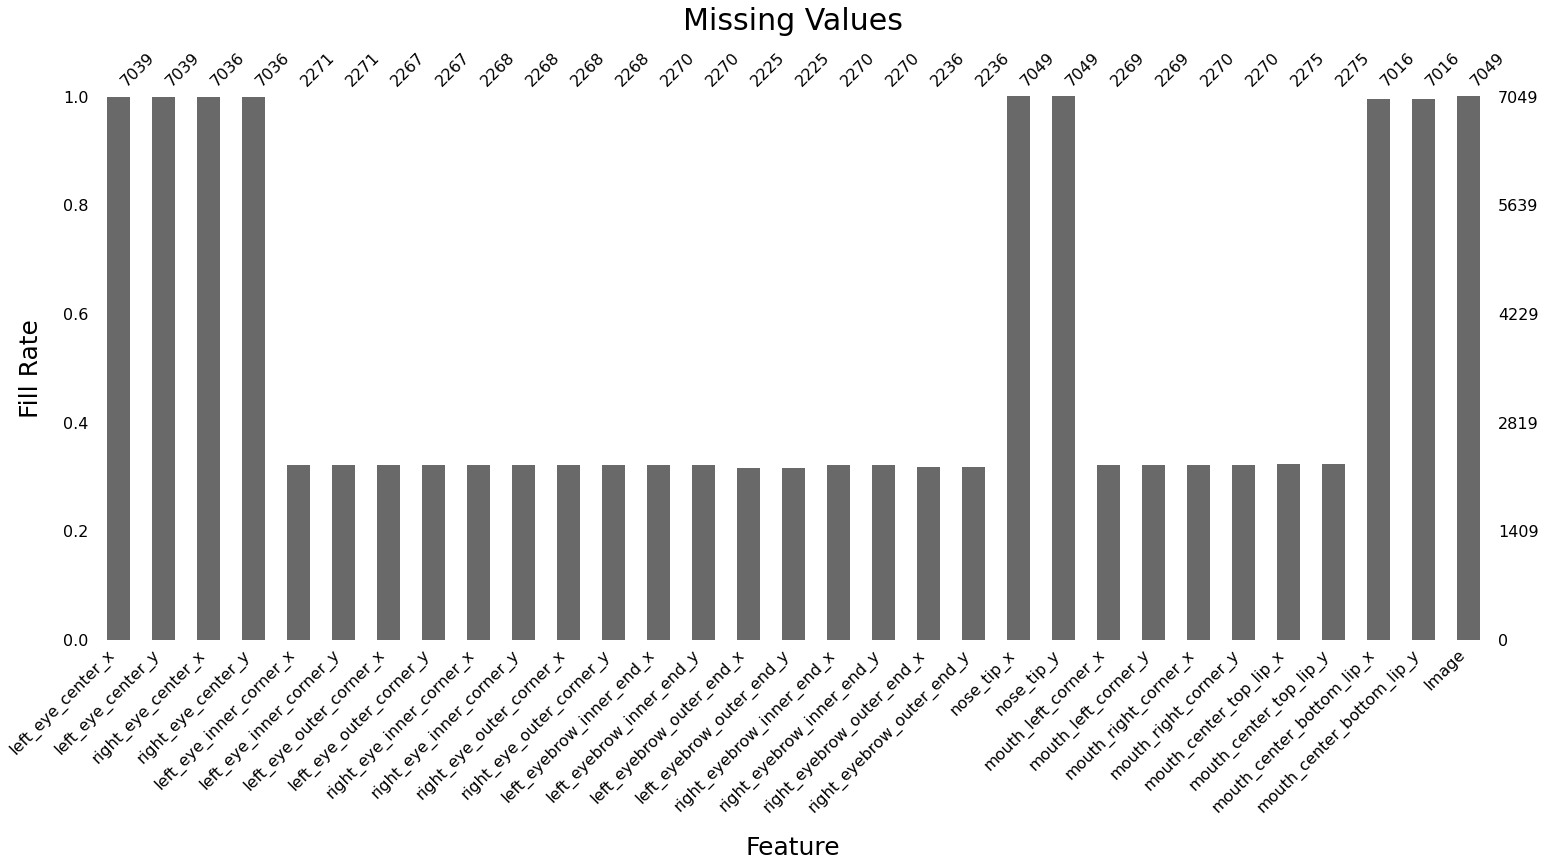

In [6]:
# view missing values
fig, ax = plt.subplots()
msno.bar(train)
ax.set_title("Missing Values", fontsize = 30, pad = 20)
ax.set_xlabel("Feature", fontsize = 25, labelpad = 20)
ax.set_ylabel("Fill Rate", fontsize = 25, labelpad = 20)
plt.show()

In [7]:
# drop NAs from train
train_noNA_temp = train.dropna()

# shuffle data and split into train and test
shuffle = np.random.permutation(np.arange(train_noNA_temp.shape[0]))
dev_set = train_noNA_temp[:500]
train_noNA = train_noNA_temp[500:]

# define function to load image data
def load_images(image_data):
    images = []
    for idx, sample in image_data.iterrows():
        image = np.array(sample['Image'].split(' '), dtype=int)
        image = np.reshape(image, (96,96,1))
        images.append(image)
    images = np.array(images)/255.
    return images

def load_labels(label_data):
    label_data = label_data.drop(['Image'], axis=1)
    label_features = []
    for idx, features in label_data.iterrows():
        label_features.append(features)
    label_features = np.array(label_features, dtype=float)
    return label_features

#Dataset with only no NA rows
train_data_noNA  = load_images(train_noNA)
train_labels_noNA = load_labels(train_noNA)


#Dev set for testing
dev_data = load_images(dev_set)
dev_labels = load_labels(dev_set)

#Test images for Kaggle competition
test_images = load_images(test)

print(train_noNA.shape, dev_set.shape)

(1640, 31) (500, 31)


In [9]:
#Create function for showing images
def show_images(data, labels, num_examples=3):

  #transform data  into 2D matrix
  X2D = np.reshape(data, (-1, 96, 96))

  num = num_examples * 3
  count = 0

  #create a figure
  fig, axes = plt.subplots(num_examples, 3, figsize = (9.6, 9.6))


  #iterate across the row of images and display one image in each of the num_examples boxes
  for n in range(num):
      ax = axes[count//num_examples, count%num_examples]
      # rand = randrange(0, len(data))
      # ax.imshow(X2D[rand], cmap = 'gray')
      # count += 1
      # for loc in range(0, len(labels[n]), 2):
      #     ax.plot(labels[rand][loc], labels[rand][loc+1], '*r')
      ax.imshow(X2D[n], cmap = 'gray')
      count += 1
      for loc in range(0, len(labels[n]), 2):
          ax.plot(labels[n][loc], labels[n][loc+1], '*r')

  plt.tight_layout()
  plt.show()

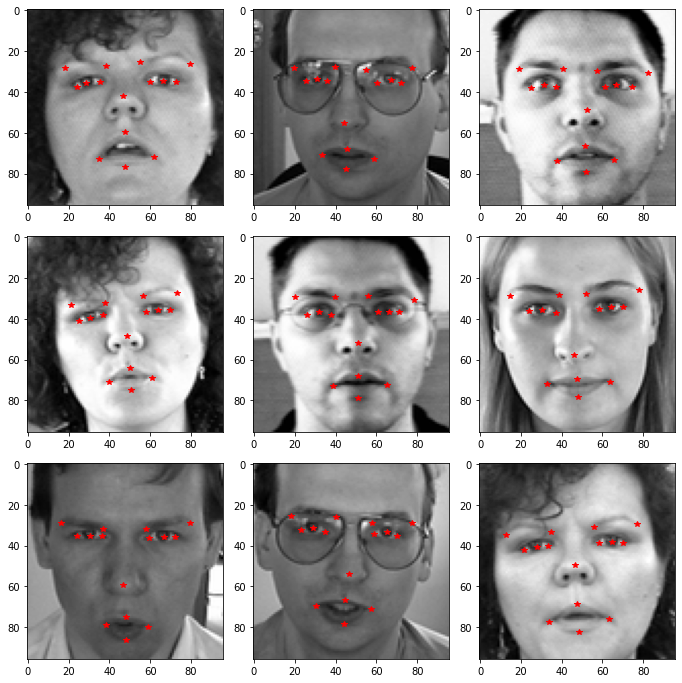

In [45]:
#Same analysis as above but with the noNA dataset - notice the how all the features are marked on the face
show_images(train_data_noNA, train_labels_noNA)

# Data Augmentation

In [10]:
# define image augmentation functions
def rotate_augmentation(images, keypoints, angles):
    rotated_images = []
    rotated_keypoints = []
    for angle in angles:    # Rotation augmentation for a list of angle values
        for angle in [angle,-angle]:
            rotation_matrix = cv2.getRotationMatrix2D((48,48), angle, 1.0)
            angle_rad = -angle*pi/180.     # Obtain angle in radians from angle in degrees (notice negative sign for change in clockwise vs anti-clockwise directions from conventional rotation to cv2's image rotation)
            # rotate images
            for image in images:
                rotated_image = cv2.warpAffine(image, rotation_matrix, (96,96), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
            rotated_images_reshaped = np.reshape(rotated_images, (-1,96,96,1))
            # rotate keypoints
            for keypoint in keypoints:
                rotated_keypoint = keypoint - 48.    # Subtract the middle value of the image dimension
                for idx in range(0, len(rotated_keypoint), 2):
                    # https://in.mathworks.com/matlabcentral/answers/93554-how-can-i-rotate-a-set-of-points-in-a-plane-by-a-certain-angle-about-an-arbitrary-point
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)
                rotated_keypoint += 48.   # Add the earlier subtracted value
                rotated_keypoints.append(rotated_keypoint)
            rotated_keypoints_reshaped = np.reshape(rotated_keypoints, (-1, 30))
    return rotated_images_reshaped, rotated_keypoints_reshaped

def alter_brightness(images, keypoints, increase_factor=1.2, decrease_factor=0.6):
    altered_brightness_images = []
    inc_brightness_images = np.clip(images*increase_factor, 0.0, 1.0)    # Increased brightness & clip any values outside the range of [-1,1]
    dec_brightness_images = np.clip(images*decrease_factor, 0.0, 1.0)    # Decreased brightness & clip any values outside the range of [-1,1]
    altered_brightness_images.extend(inc_brightness_images)
    altered_brightness_images.extend(dec_brightness_images)
    altered_brightness_images_reshaped = np.reshape(altered_brightness_images, (-1,96,96,1))
    altered_brightness_keypoints_reshaped = np.reshape(np.concatenate((keypoints, keypoints)), (-1, 30))
    return altered_brightness_images_reshaped, altered_brightness_keypoints_reshaped

def shift_images(images, keypoints, pixel_shifts):
    shifted_images = []
    shifted_keypoints = []
    for shift in pixel_shifts:    # Augmenting over several pixel shift values
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            shift_matrix = np.float32([[1,0,shift_x],[0,1,shift_y]])
            for image, keypoint in zip(images, keypoints):
                shifted_image = cv2.warpAffine(image, shift_matrix, (96,96), flags=cv2.INTER_CUBIC)
                shifted_keypoint = np.array([(point+shift_x) if idx%2==0 else (point+shift_y) for idx, point in enumerate(keypoint)])
                if np.all(0.0<shifted_keypoint) and np.all(shifted_keypoint<96.0):
                    shifted_images.append(shifted_image.reshape(96,96,1))
                    shifted_keypoints.append(shifted_keypoint)
    shifted_images_reshaped = np.reshape(shifted_images, (-1,96,96,1))
    shifted_keypoints = np.clip(shifted_keypoints,0.0,96.0)
    shifted_keypoints_reshaped = np.reshape(shifted_keypoints, (-1, 30))
    return shifted_images_reshaped, shifted_keypoints_reshaped

def add_random_noise(images, keypoints, noise_factor=0.008):
    noisy_images = []
    for image in images:
        noisy_image = cv2.add(image, noise_factor*np.random.randn(96,96,1))    # Adding random normal noise to the input image & clip the resulting noisy image between [-1,1]
        noisy_images.append(noisy_image.reshape(96,96,1))
    noisy_images_reshaped = np.reshape(noisy_images, (-1,96,96,1))
    return noisy_images_reshaped, keypoints

def guassian_blur(images, keypoints, kernel=(5,5)):
    blurred_images = []
    for image in images:
        dst = cv2.GaussianBlur(image, kernel, cv2.BORDER_DEFAULT)
        blurred_image = dst.reshape(96,96,1)
        blurred_images.append(blurred_image)
    blurred_images_reshaped = np.reshape(blurred_images, (-1,96,96,1))
    return blurred_images_reshaped, keypoints

In [11]:
print(train_data_noNA[0][0].shape)

(96, 1)


In [12]:
# rotate images and keypoints
train_data_rotated, train_labels_rotated = rotate_augmentation(train_data_noNA, train_labels_noNA, [12])

# alter brightness
train_data_brightness, train_labels_brightness = alter_brightness(
                                                        train_data_noNA,
                                                        train_labels_noNA,
                                                        increase_factor=1.2,
                                                        decrease_factor=0.6
                                                    )

# shift images and keypoints
train_data_shifted, train_labels_shifted = shift_images(train_data_noNA, train_labels_noNA, [12])

# add random noise
train_data_noise, train_labels_noise = add_random_noise(train_data_noNA, train_labels_noNA, 0.03)

# apply gaussian blur
train_data_blurred, train_labels_blurred = guassian_blur(train_data_noNA, train_labels_noNA, kernel=(5,5))

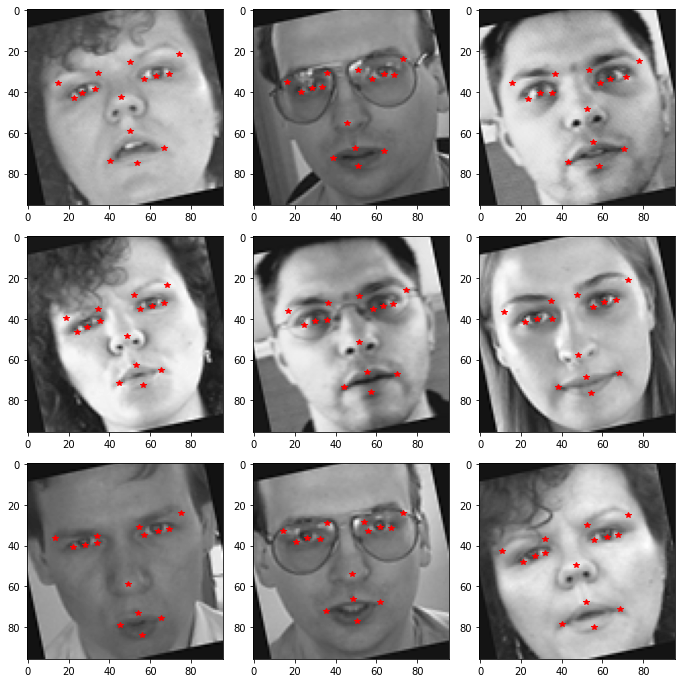

In [98]:
show_images(train_data_rotated, train_labels_rotated)

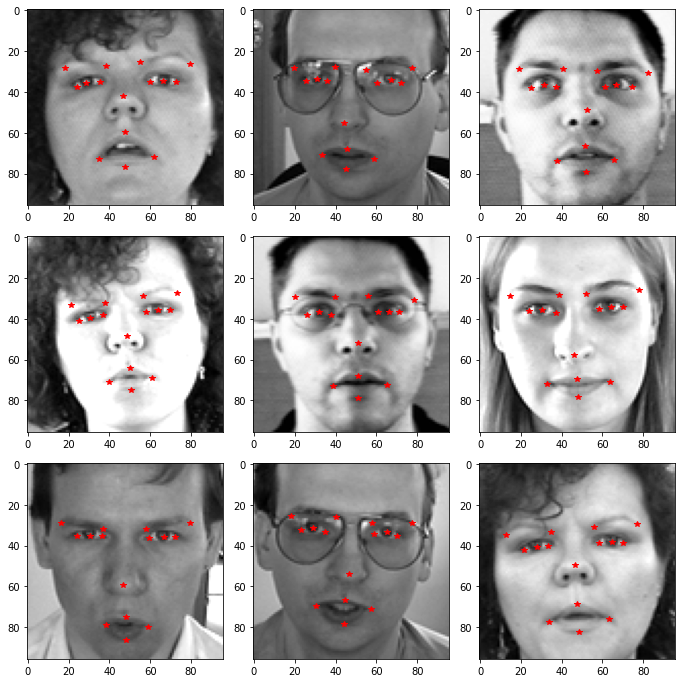

In [100]:
show_images(train_data_brightness, train_labels_brightness)

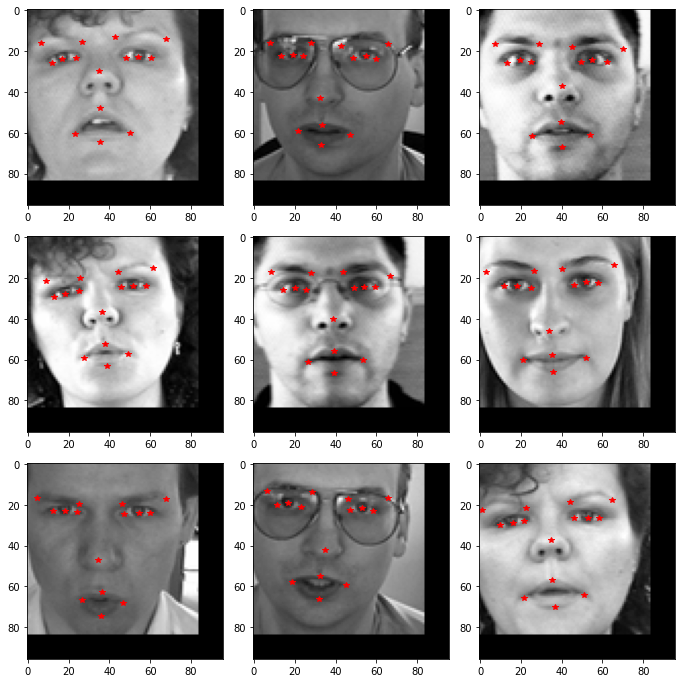

In [102]:
show_images(train_data_shifted, train_labels_shifted)

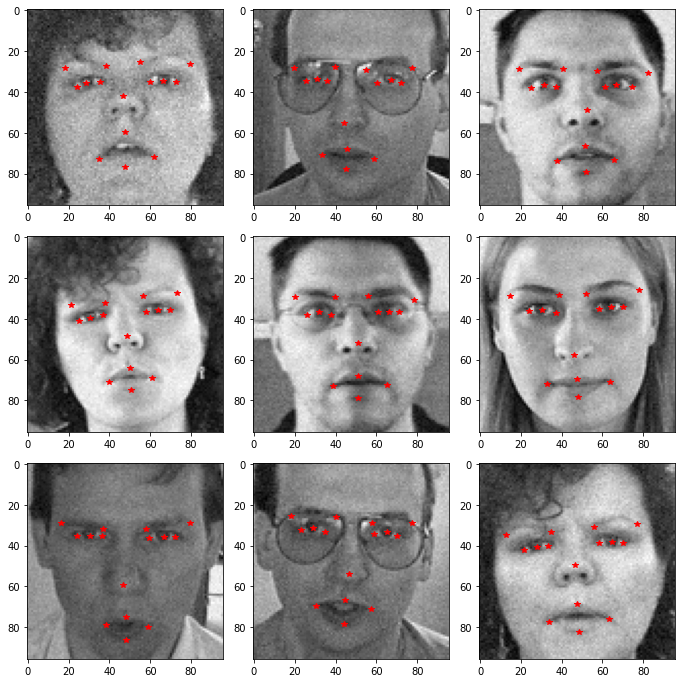

In [104]:
show_images(train_data_noise, train_labels_noise)

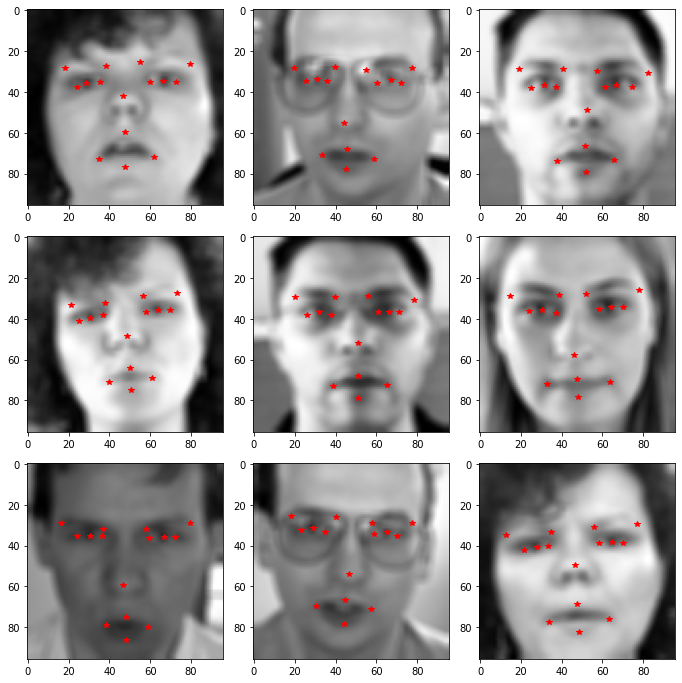

In [106]:
show_images(train_data_blurred, train_labels_blurred)

In [13]:
# merge all augmented data
train_data_aug = np.concatenate(
    (train_data_noNA, train_data_rotated, train_data_shifted, train_data_brightness, train_data_noise, train_data_blurred)
)

train_labels_aug = np.concatenate(
    (train_labels_noNA, train_labels_rotated, train_labels_shifted, train_labels_brightness, train_labels_noise, train_labels_blurred)
)

print(train_data_aug.shape)
print(train_labels_aug.shape)

(16267, 96, 96, 1)
(16267, 30)


# Modeling

In [16]:
# CNN Architecture
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Conv2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

# model.add(Conv2D(64, (3,3), padding='same', use_bias=False))
# model.add(LeakyReLU(alpha = 0.1))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
#
# model.add(Conv2D(96, (3,3), padding='same', use_bias=False))
# model.add(LeakyReLU(alpha = 0.1))
# model.add(BatchNormalization())

model.add(Flatten())

# Hidden layers
model.add(Dense(units=64, input_dim=64, activation='relu'))
model.add(Dropout(0.1))

# Output layers
model.add(Dense(units=30, input_dim=64, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 96, 96, 32)        288       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 96, 96, 32)        0         
                                                                 
 batch_normalization_4 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 96, 96, 32)        9216      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 96, 96, 32)        0         
                                                                 
 batch_normalization_5 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                      

In [18]:
# Training
earlyStopping = EarlyStopping(monitor='loss', patience=15, mode='min', baseline=None, restore_best_weights=True)

rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001, mode='min', verbose=1)

adamax_obj = tf.keras.optimizers.Adamax(
    learning_rate=0.01,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    name='Adamax'
)

model.compile(optimizer=adamax_obj, loss='mean_squared_error', metrics=['mae','acc'])

history = model.fit(
    train_data_noNA,
    train_labels_noNA,
    epochs=100,
    batch_size=64,
    shuffle = True,
    validation_data=(dev_data, dev_labels),
    callbacks=[earlyStopping, rlr]
)

Epoch 1/100
26/26 [==============================] - 31s 1s/step - loss: 2625.9116 - mae: 47.6351 - acc: 0.6494 - val_loss: 2574.7288 - val_mae: 47.2808 - val_acc: 0.0080 - lr: 0.0100
Epoch 2/100
26/26 [==============================] - 24s 922ms/step - loss: 2625.8962 - mae: 47.6351 - acc: 0.6671 - val_loss: 2574.4082 - val_mae: 47.2808 - val_acc: 0.0600 - lr: 0.0100
Epoch 3/100
26/26 [==============================] - 26s 999ms/step - loss: 2625.8962 - mae: 47.6351 - acc: 0.6671 - val_loss: 2573.8723 - val_mae: 47.2808 - val_acc: 0.1920 - lr: 0.0100
Epoch 4/100
26/26 [==============================] - 27s 1s/step - loss: 2625.8967 - mae: 47.6351 - acc: 0.6677 - val_loss: 2573.4385 - val_mae: 47.2808 - val_acc: 0.3360 - lr: 0.0100
Epoch 5/100
26/26 [==============================] - 26s 987ms/step - loss: 2625.8962 - mae: 47.6351 - acc: 0.6671 - val_loss: 2573.1101 - val_mae: 47.2808 - val_acc: 0.4840 - lr: 0.0100
Epoch 6/100
26/26 [==============================] - 28s 1s/step - loss

In [24]:
adamax_obj = tf.keras.optimizers.Adamax(
    learning_rate=0.01,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    name='Adamax'
)

model.compile(optimizer=adamax_obj, loss='mean_squared_error', metrics=['mae','acc'])

cnn_aug_history = model.fit(
    train_data_aug,
    train_labels_aug,
    epochs=100,
    batch_size=64,
    shuffle = True,
    validation_data=(dev_data, dev_labels),
    callbacks=[earlyStopping, rlr]
)

Epoch 1/100
255/255 [==============================] - 290s 1s/step - loss: 2626.2798 - mae: 47.2851 - acc: 0.5697 - val_loss: 2572.4373 - val_mae: 47.2808 - val_acc: 0.8300 - lr: 0.0100
Epoch 2/100
255/255 [==============================] - 236s 927ms/step - loss: 2626.2756 - mae: 47.2851 - acc: 0.5709 - val_loss: 2572.4373 - val_mae: 47.2808 - val_acc: 0.8300 - lr: 0.0100
Epoch 3/100
255/255 [==============================] - 229s 898ms/step - loss: 2626.2759 - mae: 47.2851 - acc: 0.5709 - val_loss: 2572.4373 - val_mae: 47.2808 - val_acc: 0.8300 - lr: 0.0100
Epoch 4/100
255/255 [==============================] - 244s 956ms/step - loss: 2626.2759 - mae: 47.2851 - acc: 0.5709 - val_loss: 2572.4373 - val_mae: 47.2808 - val_acc: 0.8300 - lr: 0.0100
Epoch 5/100
255/255 [==============================] - 254s 997ms/step - loss: 2626.2749 - mae: 47.2851 - acc: 0.5709 - val_loss: 2572.4373 - val_mae: 47.2808 - val_acc: 0.8300 - lr: 0.0100
Epoch 6/100
255/255 [==============================] 

In [47]:
def plot_learning_curves(df, metric):
    dev_metric = 'val_' + metric
    fig, ax = plt.subplots(2, 1, figsize=(20, 10))
    df.loc[:, ['loss', 'val_loss']].plot(ax=ax[0])
    df.loc[:, [metric, dev_metric]].plot(ax=ax[1])
    ax[0].set_title('Model Loss', fontsize=12)
    ax[1].set_title('Model Performance', fontsize=12)
    fig.suptitle('Model Metrics', fontsize=18)

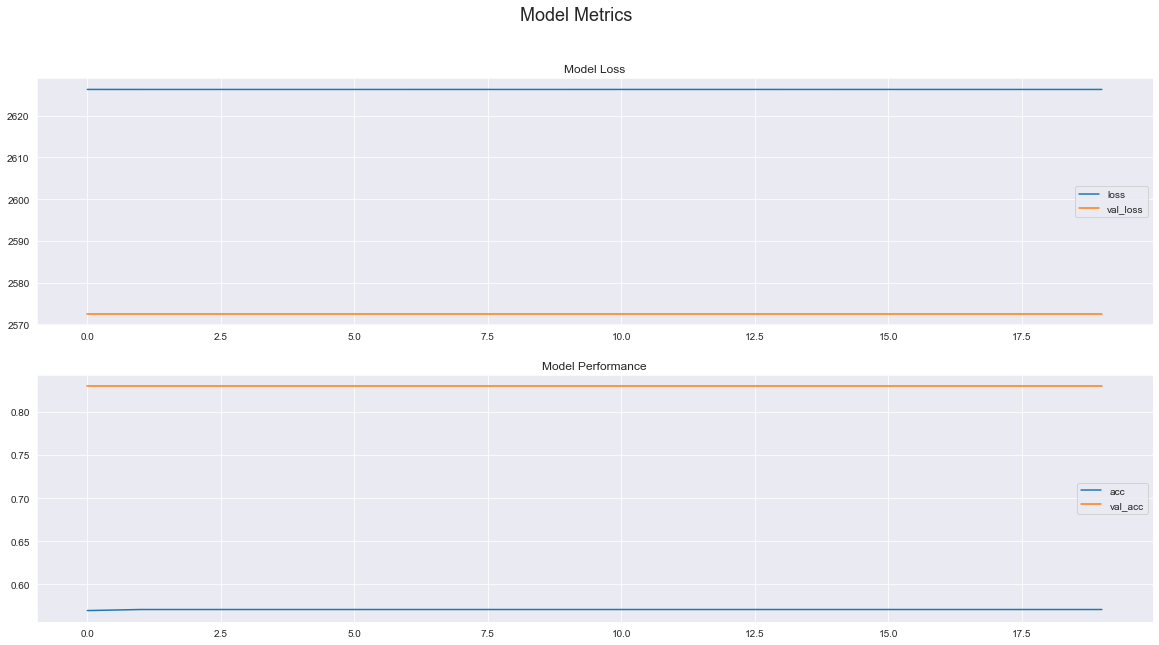

In [51]:
model_history_df = pd.DataFrame(cnn_aug_history.history)
plot_learning_curves(model_history_df, 'acc')

In [52]:
earlyStopping = EarlyStopping(monitor='loss', patience=30, mode='min',
                             baseline=None)

rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-15, mode='min', verbose=1)

In [54]:
model_CNN_noNA1 = Sequential()
model_CNN_noNA1.add(Conv2D(64, kernel_size=(3, 3),activation='relu',input_shape=(96, 96, 1)))
model_CNN_noNA1.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN_noNA1.add(Dropout(0.2))
model_CNN_noNA1.add(Flatten())
model_CNN_noNA1.add(Dense(96))
model_CNN_noNA1.add(BatchNormalization())
model_CNN_noNA1.add(Activation('relu'))
model_CNN_noNA1.add(Dense(30))


# model_CNN_noNA1.summary()

model_CNN_noNA1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history_CNN_noNA1 = model_CNN_noNA1.fit(
    train_data_noNA,
    train_labels_noNA,
    batch_size=64,
    epochs=50,
    validation_data=(dev_data, dev_labels),
    shuffle = True,
    callbacks=[earlyStopping, rlp]
)

Epoch 1/50
26/26 [==============================] - 12s 439ms/step - loss: 2577.7148 - accuracy: 0.0037 - val_loss: 2276.0625 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/50
26/26 [==============================] - 12s 437ms/step - loss: 2463.5007 - accuracy: 0.0043 - val_loss: 2367.0525 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/50
26/26 [==============================] - 10s 389ms/step - loss: 2330.4336 - accuracy: 0.0067 - val_loss: 2339.9226 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/50
26/26 [==============================] - 10s 376ms/step - loss: 2175.3489 - accuracy: 0.0110 - val_loss: 2167.4685 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/50
26/26 [==============================] - 10s 368ms/step - loss: 2002.4374 - accuracy: 0.0116 - val_loss: 2038.7064 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/50
26/26 [==============================] - 10s 368ms/step - loss: 1817.6525 - accuracy: 0.0116 - val_loss: 1717.7538 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoc

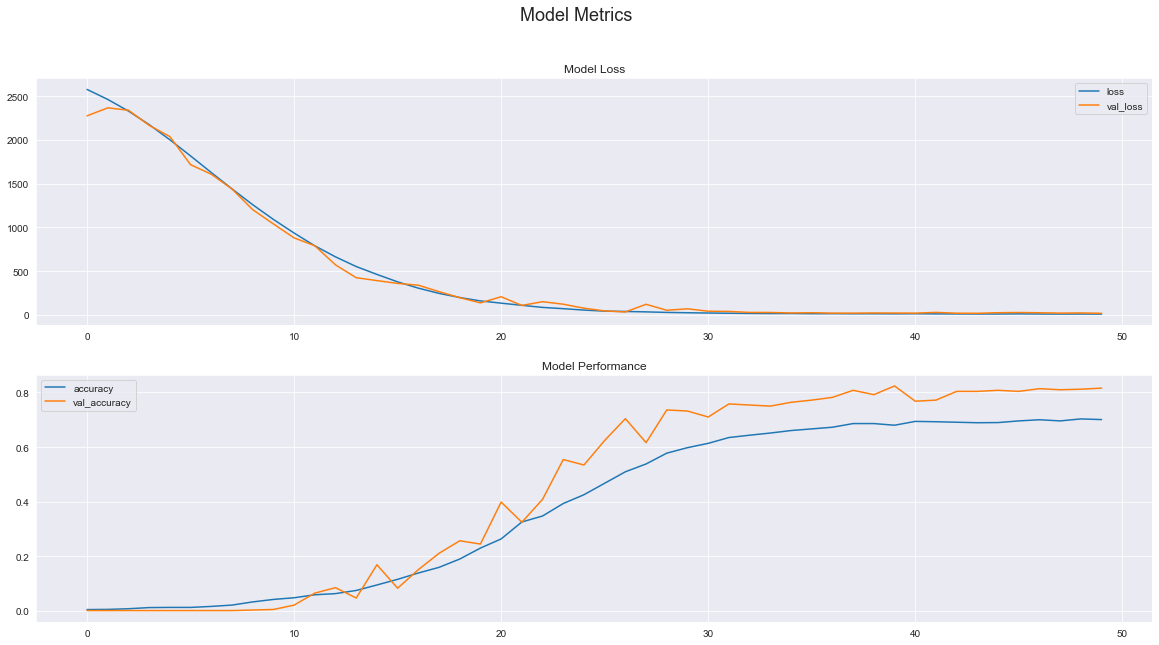

In [56]:
# out of the box Adam optimizer, lr factor of 0.7
model_history_df = pd.DataFrame(history_CNN_noNA1.history)
plot_learning_curves(model_history_df, 'accuracy')

In [69]:
# Training
earlyStopping = EarlyStopping(monitor='loss', patience=15, mode='min', baseline=None, restore_best_weights=True)

rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001, mode='min', verbose=1)

model_CNN_noNA1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

history_CNN_noNA5 = model_CNN_noNA1.fit(
    train_data_noNA,
    train_labels_noNA,
    batch_size=64,
    epochs=50,
    validation_data=(dev_data, dev_labels),
    shuffle = True,
    callbacks=[earlyStopping, rlr]
)

Epoch 1/50
26/26 [==============================] - 13s 470ms/step - loss: 0.7939 - accuracy: 0.8872 - val_loss: 1.7113 - val_accuracy: 0.8600 - lr: 0.0010
Epoch 2/50
26/26 [==============================] - 10s 381ms/step - loss: 0.8625 - accuracy: 0.8860 - val_loss: 1.6985 - val_accuracy: 0.8620 - lr: 0.0010
Epoch 3/50
26/26 [==============================] - 11s 418ms/step - loss: 0.8284 - accuracy: 0.8878 - val_loss: 1.8045 - val_accuracy: 0.8540 - lr: 0.0010
Epoch 4/50
26/26 [==============================] - 9s 354ms/step - loss: 0.8432 - accuracy: 0.8957 - val_loss: 1.7932 - val_accuracy: 0.8600 - lr: 0.0010
Epoch 5/50
26/26 [==============================] - 9s 353ms/step - loss: 0.8420 - accuracy: 0.8829 - val_loss: 1.6940 - val_accuracy: 0.8620 - lr: 0.0010
Epoch 6/50
26/26 [==============================] - 9s 352ms/step - loss: 0.8096 - accuracy: 0.8848 - val_loss: 1.7096 - val_accuracy: 0.8620 - lr: 0.0010
Epoch 7/50
26/26 [==============================] - 9s 360ms/step -

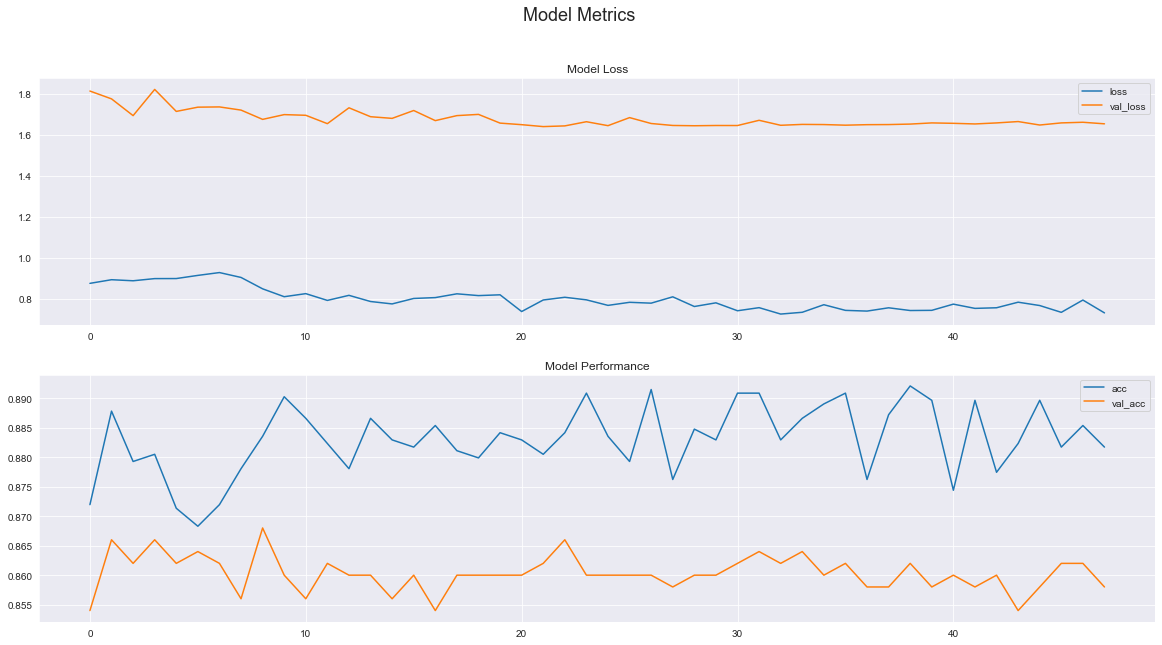

In [68]:
# adama with starting lr = 0.001, more conservative lr reduction factor
model_history_df = pd.DataFrame(history_CNN_noNA5.history)
plot_learning_curves(model_history_df, 'acc')

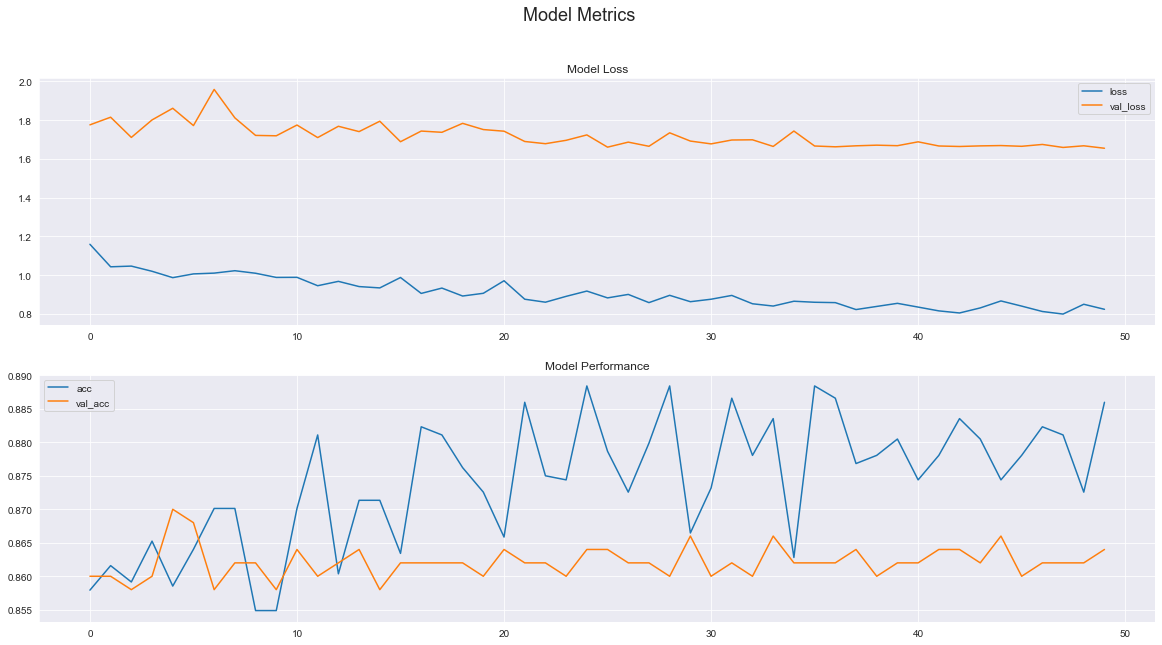

In [66]:
# adama with starting lr = 0.001
model_history_df = pd.DataFrame(history_CNN_noNA4.history)
plot_learning_curves(model_history_df, 'acc')

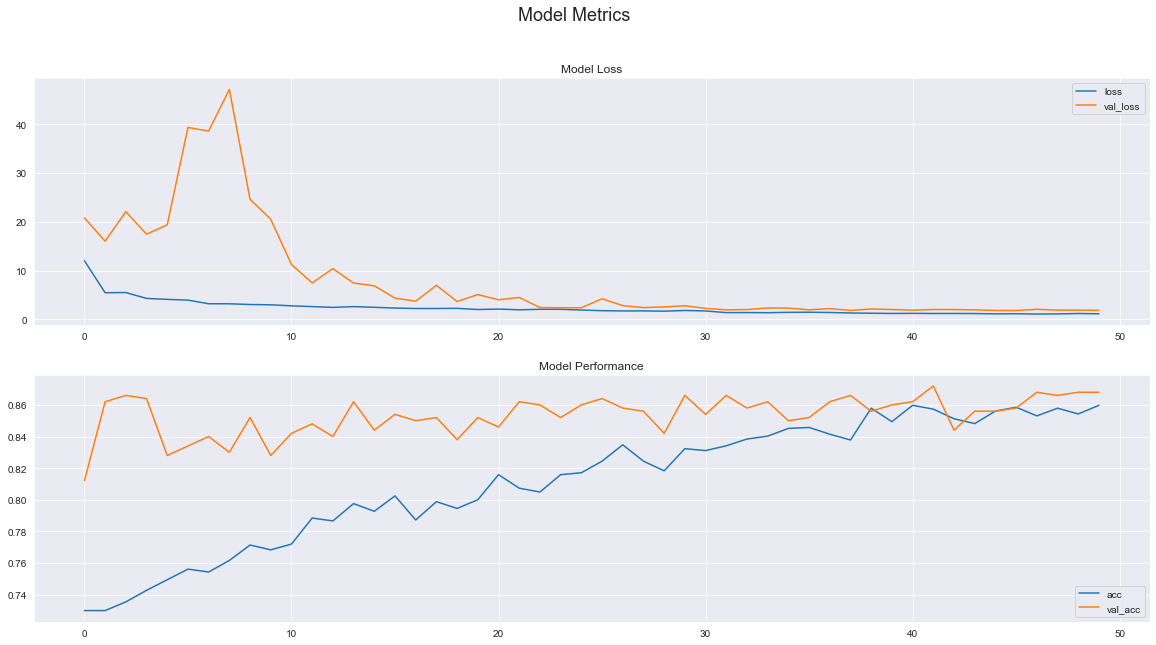

In [64]:
# adama with starting lr = 0.01
model_history_df = pd.DataFrame(history_CNN_noNA3.history)
plot_learning_curves(model_history_df, 'acc')

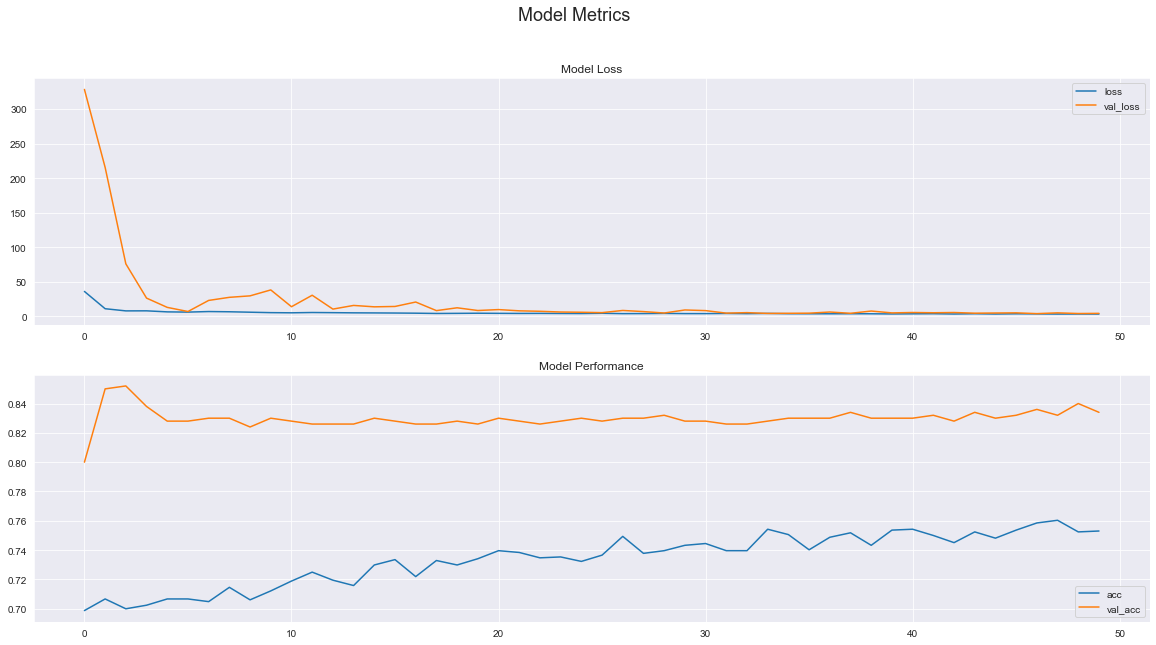

In [60]:
# adamax with starting lr = 0.01
model_history_df = pd.DataFrame(history_CNN_noNA2.history)
plot_learning_curves(model_history_df, 'acc')